In [1]:
import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from keras.applications.resnet_v2 import ResNet152V2

In [4]:
image_size = [224, 224]

In [23]:
resnet_models = ResNet152V2(input_shape=image_size + [3], weights='imagenet', include_top=False)
resnet_models.output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'post_relu')>

In [24]:
for layer in resnet_models.layers : 
    layer.trainable = False

In [2]:
chili_data = './Data/Chili/'

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


image_size = (224,224)
batch_size = 16


train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.3
)

train_generator = train_datagen.flow_from_directory(
    chili_data,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory(
    chili_data,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation'
)

test_generator = train_datagen.flow_from_directory(
    chili_data,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
    subset = 'validation'
)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './Data/Chili/'

In [27]:
x = tf.keras.layers.Flatten()(resnet_models.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
prediction = tf.keras.layers.Dense(5, activation='softmax')(x)
model = tf.keras.models.Model(inputs = resnet_models.input, outputs=prediction)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='Chili_model.h5',
                             verbose=1,
                             save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history = model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    epochs = 50,
    callbacks=callbacks,
    verbose=1
)


duration = datetime.now() - start
print("Training complete in time: ", duration)

C:\Users\yerem\AppData\Local\Temp\ipykernel_23196\1988719914.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 1.9741 - accuracy: 0.2095
Epoch 1: val_loss improved from inf to 1.93547, saving model to Chili_model.h5
27/27 [==============================] - 24s 527ms/step - loss: 1.9741 - accuracy: 0.2095 - val_loss: 1.9355 - val_accuracy: 0.2123
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 1.5607 - accuracy: 0.3214
Epoch 2: val_loss improved from 1.93547 to 1.48080, saving model to Chili_model.h5
27/27 [==============================] - 11s 397ms/step - loss: 1.5607 - accuracy: 0.3214 - val_loss: 1.4808 - val_accuracy: 0.3966
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 1.3643 - accuracy: 0.4571
Epoch 3: val_loss improved from 1.48080 to 1.25514, saving model to Chili_model.h5
27/27 [==============================] - 11s 397ms/step - loss: 1.3643 - accuracy: 0.4571 - val_loss: 1.2551 - val_accuracy: 0.4749
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 1.1799 - 

In [30]:
model.evaluate(test_generator)

12/12 [==============================] - 3s 208ms/step - loss: 0.5696 - accuracy: 0.7598


[0.5695788264274597, 0.7597765326499939]

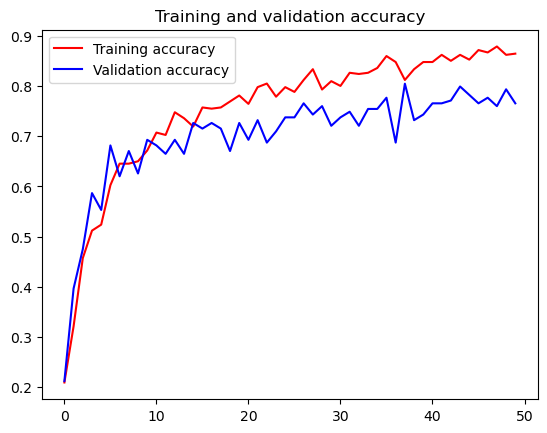

<Figure size 640x480 with 0 Axes>

In [31]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()